# Hyperparameter Tuning for Classical Machine Learning

## Introduction

**Hyperparameters** are configuration settings that are external to the model and whose values cannot be learned from the data. Unlike model parameters (such as weights in a neural network or coefficients in linear regression), hyperparameters must be set before the learning process begins. Examples include the number of trees in a Random Forest, the learning rate in gradient boosting, or the regularization strength in Logistic Regression.

Selecting appropriate hyperparameters is crucial for model performance. Poor choices can lead to underfitting (model too simple) or overfitting (model too complex). This lab will guide you through three main approaches to hyperparameter tuning:

1. **GridSearchCV** - Exhaustive search over a parameter grid
2. **RandomizedSearchCV** - Random sampling from parameter distributions
3. **Optuna** - Intelligent Bayesian optimization

By the end of this lab, you will understand when to use each approach and how to implement them effectively for classical machine learning algorithms.


In [1]:
!uv pip install scikit-learn pandas numpy optuna plotly nbformat

Using Python 3.12.11 environment at: /Users/tarekatwan/Repos/MyWork/Teach/repos/adv_ml_ds/dev1
Audited 6 packages in 8ms


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_breast_cancer
from scipy.stats import randint, uniform

# Optuna import
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


## Dataset Preparation

We'll use the **Breast Cancer Wisconsin dataset**, a classic binary classification problem. This dataset is more challenging than Iris and better demonstrates the impact of hyperparameter tuning.

The dataset contains 569 samples with 30 features computed from digitized images of breast mass. The task is to classify tumors as malignant or benign.


In [3]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dataset shape: {X.shape}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X.shape[1]}")
print(f"\nClass distribution in training set:")
print(f"  Malignant (0): {sum(y_train == 0)}")
print(f"  Benign (1): {sum(y_train == 1)}")


Dataset shape: (569, 30)
Training samples: 455
Test samples: 114
Number of features: 30

Class distribution in training set:
  Malignant (0): 170
  Benign (1): 285


## Baseline Model

Before tuning hyperparameters, let's establish a baseline using default parameters. This gives us a reference point to measure improvement.


In [4]:
# Train a Random Forest with default parameters
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)

# Evaluate on test set
y_pred_baseline = rf_baseline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Random Forest Accuracy: {baseline_accuracy:.4f}")
print(f"\nDefault parameters used:")
for param, value in rf_baseline.get_params().items():
    if param in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']:
        print(f"  {param}: {value}")


Baseline Random Forest Accuracy: 0.9561

Default parameters used:
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100


## 1. GridSearchCV: Exhaustive Parameter Search

**GridSearchCV** performs an exhaustive search over a specified parameter grid. It evaluates all possible combinations of parameters using cross-validation.

### How it works:
1. Define a grid of parameter values
2. For each combination, train the model using cross-validation
3. Select the combination with the best cross-validation score

### Advantages:
- Guaranteed to find the best combination within the specified grid
- Simple and straightforward to implement
- Reproducible results

### Disadvantages:
- Computationally expensive (grows exponentially with parameters)
- May miss optimal values between grid points
- Inefficient for large parameter spaces

### When to use:
- Small parameter spaces (few parameters, few values each)
- When computational resources are available
- When you need to guarantee finding the best combination in a limited space


In [5]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Calculate total combinations
total_combinations = 1
for param_values in param_grid_rf.values():
    total_combinations *= len(param_values)
print(f"Total combinations to evaluate: {total_combinations}")
print(f"With 5-fold CV, total fits: {total_combinations * 5}\n")

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,
    scoring='accuracy'
)

# Fit the grid search
print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)

# Display results
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred_grid = grid_search.best_estimator_.predict(X_test)
grid_accuracy = accuracy_score(y_test, y_pred_grid)
print(f"Test set accuracy: {grid_accuracy:.4f}")
print(f"Improvement over baseline: {(grid_accuracy - baseline_accuracy):.4f}")


Total combinations to evaluate: 216
With 5-fold CV, total fits: 1080

Starting GridSearchCV...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9604
Test set accuracy: 0.9561
Improvement over baseline: 0.0000

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9604
Test set accuracy: 0.9561
Improvement over baseline: 0.0000


## 2. RandomizedSearchCV: Efficient Random Sampling

**RandomizedSearchCV** samples a fixed number of parameter combinations from specified distributions. Instead of trying every combination, it randomly samples from the parameter space.

### How it works:
1. Define probability distributions for each parameter
2. Randomly sample parameter combinations
3. Evaluate each combination using cross-validation
4. Select the best performing combination

### Advantages:
- Much faster than GridSearchCV for large parameter spaces
- Can explore a wider range of values using distributions
- Budget can be controlled independently of parameter space size
- Often finds near-optimal solutions quickly

### Disadvantages:
- No guarantee of finding the absolute best combination
- Results may vary between runs (though can be controlled with random_state)

### When to use:
- Large parameter spaces where GridSearchCV is too slow
- When you want to explore continuous or very large discrete ranges
- When you have a limited computational budget
- As a first pass before refining with GridSearchCV


In [6]:
from scipy.stats import randint, uniform

# Define parameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 300),  # Random integers between 50 and 300
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=100,  # Number of random combinations to try
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    scoring='accuracy'
)

# Fit the random search
print("Starting RandomizedSearchCV...")
print(f"Will evaluate 100 random combinations (500 total fits with 5-fold CV)\n")
random_search.fit(X_train, y_train)

# Display results
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Evaluate on test set
y_pred_random = random_search.best_estimator_.predict(X_test)
random_accuracy = accuracy_score(y_test, y_pred_random)
print(f"Test set accuracy: {random_accuracy:.4f}")
print(f"Improvement over baseline: {(random_accuracy - baseline_accuracy):.4f}")


Starting RandomizedSearchCV...
Will evaluate 100 random combinations (500 total fits with 5-fold CV)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 283}
Best cross-validation score: 0.9604
Test set accuracy: 0.9474
Improvement over baseline: -0.0088

Best parameters found: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 283}
Best cross-validation score: 0.9604
Test set accuracy: 0.9474
Improvement over baseline: -0.0088


## 3. Optuna: Intelligent Bayesian Optimization

**Optuna** is a modern hyperparameter optimization framework that uses sophisticated algorithms to intelligently search the parameter space. Unlike grid or random search, Optuna learns from previous trials to make informed decisions about which parameters to try next.

### How it works:
1. Define an objective function that returns a metric to optimize
2. Optuna uses **Tree-structured Parzen Estimator (TPE)** by default
3. Each trial informs the next: promising regions are explored more
4. Can automatically prune unpromising trials early

### Key Advantages:
- **Intelligent Search**: Uses Bayesian optimization to focus on promising regions
- **Pruning**: Stops unpromising trials early, saving computation
- **Flexibility**: Easy to define conditional and complex parameter spaces
- **Dynamic**: Can add/remove parameters without restructuring code
- **Visualization**: Built-in tools to analyze optimization process

### When to use:
- Large and complex hyperparameter spaces
- When you want the most efficient search
- When computational budget is limited
- When you need conditional parameters (e.g., different params for different models)
- For production systems where finding optimal parameters is critical


In [7]:
# Suppress Optuna's verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_rf(trial):
    """
    Objective function for Optuna to optimize.
    
    Args:
        trial: Optuna trial object
        
    Returns:
        Cross-validation accuracy score
    """
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    # Create model with suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Evaluate using cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return cv_scores.mean()

# Create study and optimize
print("Starting Optuna optimization...")
study_rf = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study_rf.optimize(objective_rf, n_trials=100, show_progress_bar=True)

# Display results
print(f"\nBest parameters found: {study_rf.best_params}")
print(f"Best cross-validation score: {study_rf.best_value:.4f}")

# Train final model with best parameters and evaluate on test set
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)
y_pred_optuna = best_rf.predict(X_test)
optuna_accuracy = accuracy_score(y_test, y_pred_optuna)

print(f"Test set accuracy: {optuna_accuracy:.4f}")
print(f"Improvement over baseline: {(optuna_accuracy - baseline_accuracy):.4f}")


Starting Optuna optimization...


Best trial: 32. Best value: 0.958242: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Best parameters found: {'n_estimators': 289, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Best cross-validation score: 0.9582
Test set accuracy: 0.9561
Improvement over baseline: 0.0000


### Optuna with Multiple Algorithms

One of Optuna's strengths is the ability to easily optimize across different algorithms. Let's compare Random Forest, Gradient Boosting, and Logistic Regression.


In [8]:
def objective_multi_model(trial):
    """
    Objective function that selects and optimizes different classifiers.
    """
    # First, suggest which classifier to use
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'GradientBoosting', 'LogisticRegression'])
    
    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
        max_depth = trial.suggest_int('rf_max_depth', 5, 50)
        min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
        
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
    
    elif classifier_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('gb_n_estimators', 50, 300)
        learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('gb_max_depth', 3, 10)
        
        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )
    
    else:  # LogisticRegression
        C = trial.suggest_float('lr_C', 0.001, 100, log=True)
        penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2'])
        solver = 'liblinear'  # Required for l1 penalty
        
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            random_state=42,
            max_iter=1000
        )
    
    # Evaluate using cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return cv_scores.mean()

# Create and run study
print("Optimizing across multiple algorithms...")
study_multi = optuna.create_study(direction='maximize')
study_multi.optimize(objective_multi_model, n_trials=150, show_progress_bar=True)

print(f"\nBest algorithm: {study_multi.best_params['classifier']}")
print(f"Best parameters: {study_multi.best_params}")
print(f"Best cross-validation score: {study_multi.best_value:.4f}")


Optimizing across multiple algorithms...


Best trial: 51. Best value: 0.973626: 100%|██████████| 150/150 [01:00<00:00,  2.50it/s]


Best algorithm: GradientBoosting
Best parameters: {'classifier': 'GradientBoosting', 'gb_n_estimators': 175, 'gb_learning_rate': 0.2979384593276022, 'gb_max_depth': 3}
Best cross-validation score: 0.9736


### Optuna Visualizations: Understanding the Optimization Process

Optuna provides powerful visualization tools that help us understand how the optimization process works and which parameters are most important. These visualizations demonstrate why Optuna is more efficient than random or grid search.



In [13]:
# 1. Optimization History: Shows how the objective value improved over trials
print("=== Optimization History ===")
print("This plot shows how Optuna improved the objective value over time.")
print("Notice how it quickly finds good solutions and continues to refine them.\n")

fig_history = plot_optimization_history(study_rf)
fig_history.show()



=== Optimization History ===
This plot shows how Optuna improved the objective value over time.
Notice how it quickly finds good solutions and continues to refine them.



In [ ]:
# 2. Parameter Importance: Shows which parameters had the most impact on performance
print("\n=== Parameter Importance ===")
print("This visualization shows which hyperparameters were most important for the optimization.")
print("Notice how some parameters like n_estimators and max_depth have much higher importance than others!\n")

fig_importance = plot_param_importances(study_rf)
fig_importance.show()




=== Parameter Importance ===
This visualization shows which hyperparameters were most important for the optimization.
Notice how different parameters matter for different algorithms!



In [15]:
# 3. Parallel Coordinate Plot: Shows relationships between parameters and objective value
print("\n=== Parallel Coordinate Plot ===")
print("This plot shows how different parameter combinations relate to performance.")
print("Lines represent individual trials, colored by objective value (brighter = better).")
print("You can see how Optuna explores the parameter space intelligently!\n")

from optuna.visualization import plot_parallel_coordinate
fig_parallel = plot_parallel_coordinate(study_rf)
fig_parallel.show()




=== Parallel Coordinate Plot ===
This plot shows how different parameter combinations relate to performance.
Lines represent individual trials, colored by objective value (brighter = better).
You can see how Optuna explores the parameter space intelligently!



In [16]:
# 4. Slice Plot: Shows how individual parameters affect the objective value
print("\n=== Slice Plot ===")
print("This plot shows the relationship between each parameter and the objective value.")
print("The vertical lines show the current best values for each parameter.\n")

from optuna.visualization import plot_slice
fig_slice = plot_slice(study_rf)
fig_slice.show()




=== Slice Plot ===
This plot shows the relationship between each parameter and the objective value.
The vertical lines show the current best values for each parameter.



### Why These Visualizations Matter

The visualizations above demonstrate several key advantages of Optuna over traditional hyperparameter tuning methods:

1. **Intelligent Exploration**: The optimization history shows how Optuna quickly identifies promising regions and refines them, rather than randomly sampling like RandomizedSearchCV.

2. **Parameter Insights**: The parameter importance plot reveals which hyperparameters actually matter for your specific problem, helping you focus future tuning efforts. For Random Forest, we can see which parameters like tree depth or number of estimators have the biggest impact on performance.

3. **Visual Parameter Relationships**: The parallel coordinate and slice plots show how different parameter combinations relate to performance, making it easy to understand the optimization landscape.

4. **Visual Debugging**: These plots help you understand if your parameter ranges are appropriate and if the optimization is working correctly.

5. **Reproducibility and Analysis**: Optuna's visualizations make it easy to share and analyze optimization results, which is crucial for production deployments.

Unlike GridSearchCV (which is exhaustive but inefficient) and RandomizedSearchCV (which is fast but uninformed), Optuna learns from each trial to make smarter decisions about where to search next. This Bayesian optimization approach is particularly powerful for efficiently exploring complex parameter spaces, as demonstrated with the Random Forest optimization above.



## Comparison and Summary

Let's compare the three approaches we've explored:


            Method  Test Accuracy  Improvement
          Baseline       0.956140     0.000000
      GridSearchCV       0.956140     0.000000
RandomizedSearchCV       0.947368    -0.008772
       Optuna (RF)       0.956140     0.000000
    Optuna (Multi)       0.973626     0.017486


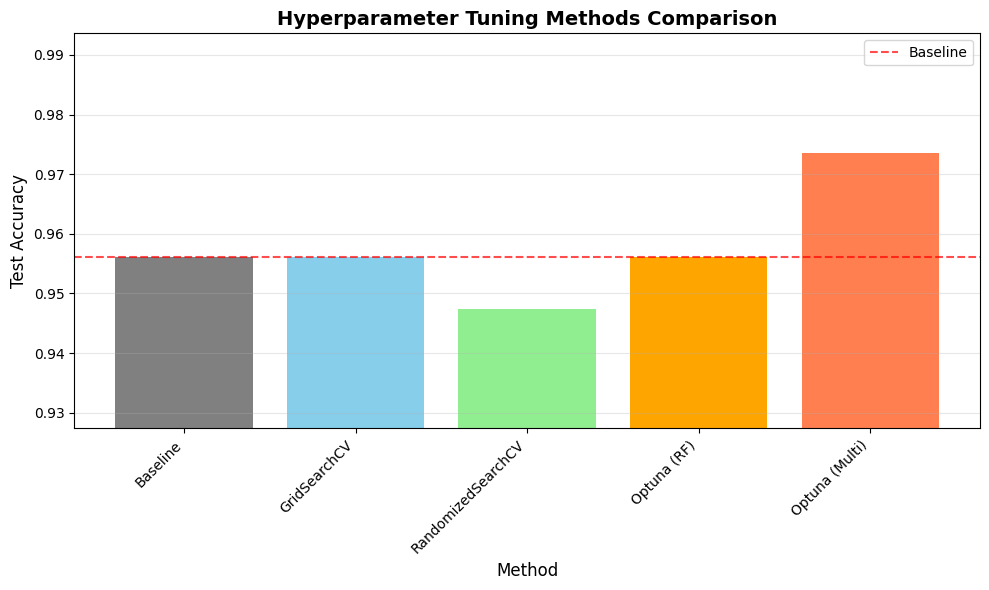

In [17]:
# Create comparison table
results = {
    'Method': ['Baseline', 'GridSearchCV', 'RandomizedSearchCV', 'Optuna (RF)', 'Optuna (Multi)'],
    'Test Accuracy': [
        baseline_accuracy,
        grid_accuracy,
        random_accuracy,
        optuna_accuracy,
        study_multi.best_value
    ],
    'Improvement': [
        0,
        grid_accuracy - baseline_accuracy,
        random_accuracy - baseline_accuracy,
        optuna_accuracy - baseline_accuracy,
        study_multi.best_value - baseline_accuracy
    ]
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Visualize results
plt.figure(figsize=(10, 6))
methods = results_df['Method']
accuracies = results_df['Test Accuracy']

bars = plt.bar(methods, accuracies, color=['gray', 'skyblue', 'lightgreen', 'orange', 'coral'])
plt.axhline(y=baseline_accuracy, color='red', linestyle='--', label='Baseline', alpha=0.7)
plt.ylabel('Test Accuracy', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.title('Hyperparameter Tuning Methods Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([min(accuracies) - 0.02, max(accuracies) + 0.02])
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


## Decision Guide: When to Use Each Method

| Criterion | GridSearchCV | RandomizedSearchCV | Optuna |
|-----------|--------------|-------------------|---------|
| **Parameter Space Size** | Small (< 100 combinations) | Medium to Large | Any size |
| **Computational Budget** | High | Medium | Low to Medium |
| **Optimization Goal** | Exhaustive search | Quick exploration | Efficient optimization |
| **Reproducibility** | Perfect | Good (with random_state) | Good (with seed) |
| **Ease of Use** | Very Easy | Very Easy | Easy |
| **Conditional Parameters** | No | No | Yes |
| **Early Stopping** | No | No | Yes (pruning) |
| **Best For** | Small grids, thorough search | Initial exploration, large spaces | Production, complex spaces |

### Practical Recommendations:

**Use GridSearchCV when:**
- You have a small, well-defined parameter space
- You want to guarantee finding the best combination within your grid
- Computational time is not a constraint
- You're doing a final refinement in a narrow range

**Use RandomizedSearchCV when:**
- You're exploring a large parameter space for the first time
- You want to quickly identify promising regions
- You have a fixed computational budget
- You're using continuous distributions for parameters

**Use Optuna when:**
- You need the most efficient search possible
- You're working with complex, conditional parameter spaces
- Computational resources are limited
- You want to leverage previous trial information
- You need pruning to stop unpromising trials early
- You're deploying to production and need optimal performance

### Hybrid Approach:
A common strategy is to:
1. Start with **RandomizedSearchCV** to explore the space broadly
2. Use **Optuna** to refine and find optimal parameters efficiently
3. Optionally use **GridSearchCV** for final fine-tuning in a narrow range


## Best Practices for Hyperparameter Tuning

### 1. Always Use Cross-Validation
Never tune hyperparameters on the test set. Use cross-validation on the training set, then evaluate the final model on the held-out test set.

### 2. Understand Your Parameters
Know what each hyperparameter does and its typical range. This helps you define sensible search spaces.

### 3. Use Appropriate Distributions
- For parameters that span orders of magnitude (e.g., learning rate), use log-uniform distributions
- For discrete counts, use integer distributions
- For bounded continuous values, use uniform distributions

### 4. Start Broad, Then Refine
Begin with a wide search space to explore, then narrow down based on results.

### 5. Monitor for Overfitting
If cross-validation scores are much higher than test scores, you may be overfitting to your validation folds.

### 6. Consider Computational Cost
Balance the number of trials/combinations with available computational resources and time constraints.

### 7. Use Parallel Processing
Most methods support `n_jobs=-1` to use all CPU cores, significantly speeding up the search.

### 8. Save Your Results
Keep track of hyperparameter searches and their results for future reference and reproducibility.


## Exercise: Try It Yourself!

Now it's your turn! Try the following exercises to reinforce your learning:

### Exercise 1: XGBoost Tuning
Install XGBoost (`pip install xgboost`) and use Optuna to tune an XGBoost classifier on this dataset. Key parameters to tune:
- `n_estimators`: Number of boosting rounds
- `max_depth`: Maximum tree depth
- `learning_rate`: Step size shrinkage
- `subsample`: Fraction of samples used for each tree
- `colsample_bytree`: Fraction of features used for each tree

### Exercise 2: Compare Timing
Measure and compare the execution time of GridSearchCV, RandomizedSearchCV, and Optuna for the same parameter space.

### Exercise 3: Visualize Optuna Results
Use Optuna's visualization functions to analyze the optimization process:
```python
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(study_rf)
plot_param_importances(study_rf)
```

### Exercise 4: Custom Scoring
Modify the examples to optimize for a different metric (e.g., F1-score, ROC-AUC) instead of accuracy.


## Additional Resources

### Documentation:
- [Scikit-learn: Tuning Hyperparameters](https://scikit-learn.org/stable/modules/grid_search.html)
- [Optuna Documentation](https://optuna.readthedocs.io/)
- [Scipy Stats Distributions](https://docs.scipy.org/doc/scipy/reference/stats.html)

### Further Reading:
- Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. *Journal of Machine Learning Research*, 13(1), 281-305.
- Akiba, T., Sano, S., Yanase, T., Ohta, T., & Koyama, M. (2019). Optuna: A next-generation hyperparameter optimization framework. *Proceedings of the 25th ACM SIGKDD*.

### Tips:
- Always validate on a separate test set
- Consider the trade-off between search time and performance gain
- Document your hyperparameter choices and search process
- Use version control for your hyperparameter configurations

---

**Happy tuning! 🎯**
